# Creating a bias detector
Purpose of this notebook is to buil a predictor using BERT capable of understanding the level of bias of an article/speech. The task is thus divided into two subtasks:
 - Detecting whether there is a bias
 - Detecting whether it is a bias towards the right or the left of the political spectrum

## Install and imports

In [ ]:
!pip3 install -q tensorflow_gpu==2.3.0

     |████████████████████████████████| 320.4MB 53kB/s 


In [ ]:
!pip3 install -q ktrain

     |████████████████████████████████| 25.3MB 138kB/s 
     |████████████████████████████████| 983kB 51.8MB/s 
     |████████████████████████████████| 266kB 38.9MB/s 
     |████████████████████████████████| 1.3MB 36.4MB/s 
     |████████████████████████████████| 471kB 49.5MB/s 
     |████████████████████████████████| 2.9MB 52.4MB/s 
     |████████████████████████████████| 890kB 54.9MB/s 
     |████████████████████████████████| 1.1MB 44.7MB/s 


In [ ]:
!pip install newspaper3k

     |████████████████████████████████| 215kB 2.7MB/s 
     |████████████████████████████████| 92kB 5.4MB/s 
     |████████████████████████████████| 7.4MB 6.8MB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
  Created wheel for jieba3k: filename=jieba3k-0.35.1-cp36-none-any.whl size=7398406 sha256=761a1e08625f6b8c8210a2cca8a6ce26a241faac9f90140a9d5e68668e5a1376
  Stored in directory: /root/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35da20627c013f438ed34
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-cp36-none-any.whl size=13538 sha256=046093b1f52767c5439521cecdfb33916d71f92539637a3f8e0eeb40f818f620
  Stored in directory: /root/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c7710628e91b8b0dc0f02
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-cp36-none-any.whl size=3355 sha256=858c6fc7763b9639fad88e333ba31ecd813b74e6f41426987c32dd046cd6974d
  Stored in directory: /root/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c7

In [ ]:
import pandas as pd
import time
import random

In [ ]:
import tensorflow as tf
import pandas as pd
import ktrain
from ktrain import text
#from newspaper import Article
#from newspaper import Config
MODEL_NAME = 'bert-base-multilingual-uncased'
print(tf.__version__)
tf.test.gpu_device_name()

2.3.0


'/device:GPU:0'

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
def upload_from_drive(link, name):
  id = link.split('file/d/')[1].split('/view?usp=sharing')[0]
  downloaded = drive.CreateFile({'id': id}) 
  downloaded.GetContentFile(name) 

In [ ]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

drive_service = build('drive', 'v3', cache_discovery=False)

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, mimetype='application/octet-stream', resumable=True)

  created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created

## Datasets
We will be using the following two datasets:
 - A collection of Wikipedia sentences that were edited because they didn't respect Wikipedia's NPOV (Neutral Point of View) policy. The creation of this dataset is explained in the article [Automatically Neutralizing Subjective Bias in Text](https://arxiv.org/pdf/1911.09709.pdf).
 - A collection of articles that were classified through crowdsourcing on how supportive they were towards democrats/republicans. Dataset creation process is explained article [Quantifying News Media Bias through Crowdsourcing and Machine Learning Dataset](https://deepblue.lib.umich.edu/data/concern/data_sets/8w32r569d?locale=en)



### Wikipedia dataset
The dataset link can be found on the [GitHub page](https://github.com/rpryzant/neutralizing-bias) of the authors

In [ ]:
!wget http://bit.ly/bias-corpus
!unzip bias-corpus

--2020-10-06 17:13:47--  http://bit.ly/bias-corpus
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://nlp.stanford.edu/projects/bias/bias_data.zip [following]
--2020-10-06 17:13:48--  http://nlp.stanford.edu/projects/bias/bias_data.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/projects/bias/bias_data.zip [following]
--2020-10-06 17:13:48--  https://nlp.stanford.edu/projects/bias/bias_data.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109612243 (105M) [application/zip]
Saving to: ‘bias-corpus’

bias-corpus         100%[===================>] 104.53M  17.2MB/s    i

In [ ]:
#I'm using the same column name as specified in the README file
df = pd.read_csv('bias_data/WNC/biased.full', sep='\t', error_bad_lines=False, names=['id', 'src_tok', 'tgt_tok', 'src_raw', 'tgt_raw', 'src_POS_tags', 'tgt_parse_tags'])
len(df)

181474

In [ ]:
#Clean the dataset
df = df.drop(df.columns.difference(['src_raw', 'tgt_raw']), axis=1)
df = df.rename(columns={'src_raw':'unedited', 'tgt_raw': 'edited'})

To obtain a dataset divided by biased and unbiased sentence, we split the original dataset into two equally long pieces. From one, we take the unedited sentences (these will be biased examples), from the other, we take the edited ones (these will be neutral examples).

In [ ]:
df_biased   = pd.DataFrame(df[:int(len(df)/2)]['unedited']).rename(columns={'unedited':'sentence'})
df_unbiased = pd.DataFrame(df[int(len(df)/2):]['edited']).rename(columns={'edited': 'sentence'})

df_biased['biased'] = True
df_unbiased['biased'] = False

df_wikipedia = pd.concat([df_biased, df_unbiased])

### Newspaper dataset
This dataset can be found on the [author's website](https://deepblue.lib.umich.edu/data/concern/data_sets/8w32r569d?locale=en)

In [ ]:
!wget https://deepblue.lib.umich.edu/data/downloads/3r074t98m

--2020-10-07 11:27:01--  https://deepblue.lib.umich.edu/data/downloads/3r074t98m
Resolving deepblue.lib.umich.edu (deepblue.lib.umich.edu)... 141.213.128.141
Connecting to deepblue.lib.umich.edu (deepblue.lib.umich.edu)|141.213.128.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3071483 (2.9M) [text/tab-separated-values]
Saving to: ‘3r074t98m’

3r074t98m           100%[===================>]   2.93M  3.16MB/s    in 0.9s    

2020-10-07 11:27:02 (3.16 MB/s) - ‘3r074t98m’ saved [3071483/3071483]



In [ ]:
df = pd.read_csv('3r074t98m', sep='\t')
print("Length of the dataset: ", len(df))
df.info()

Length of the dataset:  21004
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21004 entries, 0 to 21003
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              21004 non-null  object
 1   q3               21004 non-null  object
 2   perceived        21004 non-null  int64 
 3   primary.topic    21004 non-null  object
 4   secondary.topic  21004 non-null  object
 5   democrat.vote    21004 non-null  object
 6   republican.vote  21004 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


In [ ]:
df.head()

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote
0,http://www.usatoday.com/story/news/nation/2013...,other,1,Civil Rights,Civil Rights,Neutral,Neutral
1,http://www.huffingtonpost.com/2013/05/21/senat...,News,0,Civil Rights,Civil Rights,Neutral,Neutral
2,http://www.washingtonpost.com/opinions/dont-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral
3,http://www.foxnews.com/politics/2013/04/03/oba...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral
4,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral


In [ ]:
df['democrat.vote'].unique()

array(['Neutral', 'Positive', 'SomewhatPositive', 'Negative',
       'SomewhatNegative'], dtype=object)

In [ ]:
df['democrat.feel'] = df['democrat.vote'].apply(lambda row: 'Neutral' if row == 'Neutral' else 'Positive' if row in ['Positive', 'SomewhatPositive'] else 'Negative')
df['republican.feel'] = df['republican.vote'].apply(lambda row: 'Neutral' if row == 'Neutral' else 'Positive' if row in ['Positive', 'SomewhatPositive'] else 'Negative')

I'm going to select, among the articles, the ones that have a positive feeling towards Dems and negative towards Reps or viceversa

In [ ]:
df_news = df[(((df['democrat.feel'] == 'Positive') & (df['republican.feel'] == 'Negative'))|((df['democrat.feel'] == 'Negative') & (df['republican.feel'] == 'Positive')))]

In [ ]:
df_news.columns

Index(['url', 'q3', 'perceived', 'primary.topic', 'secondary.topic',
       'democrat.vote', 'republican.vote', 'democrat.feel', 'republican.feel'],
      dtype='object')

In [ ]:
df_news['lean_left'] = df['democrat.feel'].apply(lambda row: 1 if row == 'Positive' else 0)
df_news = df_news.drop(df_news.columns.difference(['url', 'lean_left']), axis=1)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2093 entries, 12 to 21003
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        2093 non-null   object
 1   lean_left  2093 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 49.1+ KB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Now we need to retrieve the articles. To do this, we use library newspaper3k (this library makes use of the punkt dataset from nltk).

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
config = Config()
config.browser_user_agent = USER_AGENT

In [ ]:
WAITING_TIME = 1
rowNumber = 0
total_length = len(df_news)

def retrieve_article(link):

  #Just to see where we arrived
  global rowNumber
  rowNumber += 1
  percCompletion = rowNumber * 100 / total_length

  #Just to avoid that any website bans us
  time.sleep(WAITING_TIME)

  #We try to download the article; If download fails, return 'None'
  try:
    article = Article(link, config=config)
    article.download()
    article.parse()
    article.nlp()
    print("Completed row {0}/{1} - {2:.2f}% completed".format(rowNumber, total_length, percCompletion))
    return article.text
  except:
    print("Error with article on link: ", link)
    return 'None'

In [ ]:
df_news['text'] = df_news['url'].apply(retrieve_article)

Completed row 1/2093 - 0.05% completed
Completed row 2/2093 - 0.10% completed
Completed row 3/2093 - 0.14% completed
Completed row 4/2093 - 0.19% completed
Completed row 5/2093 - 0.24% completed
Completed row 6/2093 - 0.29% completed
Completed row 7/2093 - 0.33% completed
Completed row 8/2093 - 0.38% completed
Completed row 9/2093 - 0.43% completed
Completed row 10/2093 - 0.48% completed
Completed row 11/2093 - 0.53% completed
Error with article on link:  http://www.reuters.com/article/2013/01/05/us-usa-kennedy-marijuana-idUSBRE9040AF20130105
Completed row 13/2093 - 0.62% completed
Completed row 14/2093 - 0.67% completed
Error with article on link:  http://www.reuters.com/article/2013/03/01/us-usa-detroit-emergency-idUSBRE9200TI20130301
Completed row 16/2093 - 0.76% completed
Completed row 17/2093 - 0.81% completed
Error with article on link:  http://www.reuters.com/article/2013/10/30/us-usa-nutrition-food-stamps-idUSBRE99T0ZI20131030
Completed row 19/2093 - 0.91% completed
Completed r

In [ ]:
df_news.to_csv('bias_news.csv', index=False)

In [ ]:
save_file_to_drive("bias_news.csv", 'bias_news.csv')

File ID: 1kb_bfCWGLlaX0hZHIUMmRsBSCdXF40jW


{'id': '1kb_bfCWGLlaX0hZHIUMmRsBSCdXF40jW'}

In [ ]:
len(df_news[df_news['text'] != 'None'])

1672

In [ ]:
df_news = df_news[df_news['text'] != "None"]

### Second newspaper dataset
This dataset comes from Kaggle - you can find the first version [here](https://www.kaggle.com/snapcrack/all-the-news). A second, much larger version, can be found [here](https://components.one/datasets/all-the-news-2-news-articles-dataset/). This dataset is very big (~2.7million articles), but the articles are not labelled for their political leaning. Following the method explained in [this article](https://www.thebipartisanpress.com/politics/calculating-political-bias-and-fighting-partisanship-with-ai/), I'm going to label them following the general bias showed by the publisher on average. The publishers' bias will be retrieved from [Media Bias/Fact Check](https://mediabiasfactcheck.com/)

In [ ]:
!wget https://www.dropbox.com/s/cn2utnr5ipathhh/all-the-news-2-1.zip?dl=0

--2020-10-07 15:32:04--  https://www.dropbox.com/s/cn2utnr5ipathhh/all-the-news-2-1.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/cn2utnr5ipathhh/all-the-news-2-1.zip [following]
--2020-10-07 15:32:05--  https://www.dropbox.com/s/raw/cn2utnr5ipathhh/all-the-news-2-1.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7d6b977b7741c1a0d2e7d84cc7.dl.dropboxusercontent.com/cd/0/inline/BA1MFqfQtDc-X4M_Cr_czgeZLpZXJwIWEw56ntNs-B6RSNvjK2Jgw7I7I65sQT0rYq8MtO7MRc76UGPJ1I9dL_iDm4nQEiMSOvQci4EG7ky3-dunEESY25iX1x0rI2DMmh4/file# [following]
--2020-10-07 15:32:05--  https://uc7d6b977b7741c1a0d2e7d84cc7.dl.dropboxusercontent.com/cd/0/inline/BA1MFqfQtDc-X4M_Cr_czgeZLpZXJwIWEw56ntNs-B6RSNvjK2Jgw7I7I65sQT0rYq8MtO7MRc76UGPJ1I

In [ ]:
!unzip all-the-news-2-1.zip

Archive:  all-the-news-2-1.zip
  inflating: all-the-news-2-1.csv    


In [ ]:
import pandas as pd
import random

total = 2700000
sample = 500000 #File is too big to read it entirely
skip = sorted(random.sample(range(1,total),total-sample))
df = pd.read_csv('all-the-news-2-1.csv', skiprows=skip)

Since the dataset is extremely large, we make it a little bit smaller by only selecting the most recent articles

In [ ]:
df = df[~df['publication'].isna()]

In [ ]:
df = df[~df['article'].isna()]

In [ ]:
len(df)

478530

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478530 entries, 0 to 497901
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    478530 non-null  int64  
 1   Unnamed: 0.1  478530 non-null  int64  
 2   date          478530 non-null  object 
 3   year          478530 non-null  int64  
 4   month         478530 non-null  float64
 5   day           478530 non-null  int64  
 6   author        307464 non-null  object 
 7   title         478526 non-null  object 
 8   article       478530 non-null  object 
 9   url           478530 non-null  object 
 10  section       324446 non-null  object 
 11  publication   478530 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 47.5+ MB


In [ ]:
df['publication'].unique()

array(['Reuters', 'TMZ', 'Vox', 'Vice', 'Hyperallergic', 'Vice News',
       'Business Insider', 'TechCrunch', 'Axios', 'Refinery 29',
       'The Verge', 'Mashable', 'People', 'Economist', 'CNN', 'Gizmodo',
       'New Yorker', 'Wired', 'CNBC', 'New Republic', 'Fox News',
       'The Hill', 'Politico', 'The New York Times', 'Buzzfeed News',
       'Washington Post'], dtype=object)

Text(0.5, 1.0, 'Number of articles per publisher')

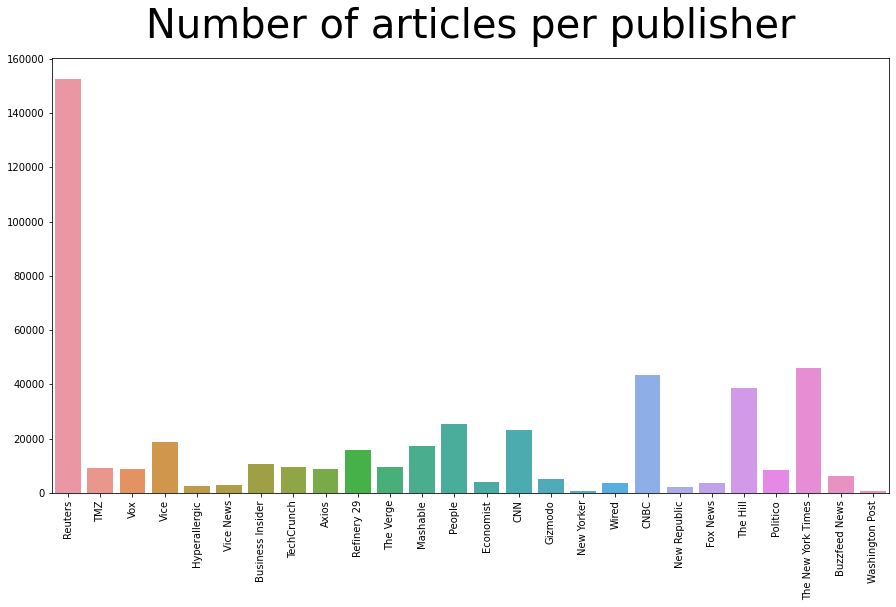

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (15,8))
plt.xticks(rotation=90, fontsize=10)
g = sns.countplot(data=df, x='publication')
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of articles per publisher', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Number of articles per publisher')

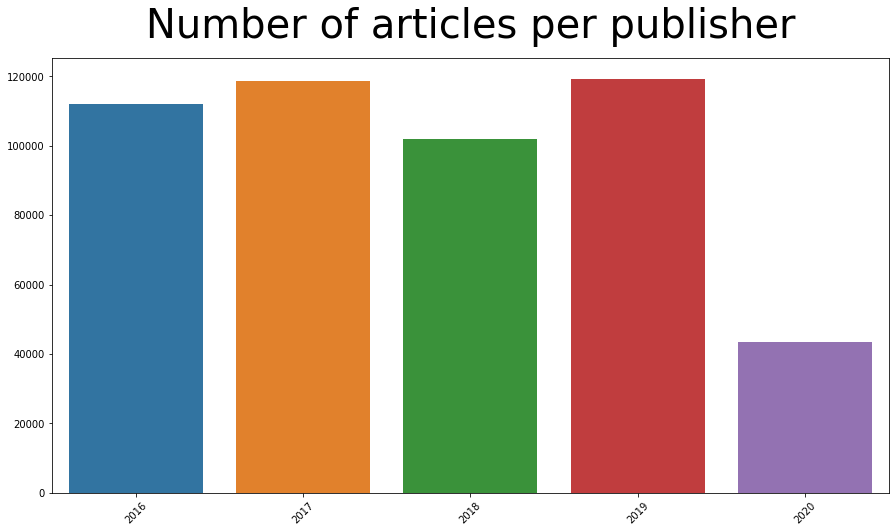

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
g = sns.countplot(data=df, x='year', order=[2016,2017,2018,2019,2020])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of articles per publisher', fontsize = 40, pad=20)

Using the Media Bias Check rating, we give every publisher a rating between -1 and 1, where -1 is extreme left and 1 is extreme right

In [ ]:
df['publication'].unique()

array(['Reuters', 'TMZ', 'Vox', 'Vice', 'Hyperallergic', 'Vice News',
       'Business Insider', 'TechCrunch', 'Axios', 'Refinery 29',
       'The Verge', 'Mashable', 'People', 'Economist', 'CNN', 'Gizmodo',
       'New Yorker', 'Wired', 'CNBC', 'New Republic', 'Fox News',
       'The Hill', 'Politico', 'The New York Times', 'Buzzfeed News',
       'Washington Post'], dtype=object)

In [ ]:
excluded_publication = ['Hyperallergic', 'TechCrunch']
df = df[~df['publication'].isin(excluded_publication)]

In [ ]:
def rate_publisher(publisher):
  if publisher == 'Reuters':
    return 0
  if publisher == 'TMZ':
    return -0.25
  if publisher == 'Vox':
    return -0.6
  if publisher == 'Vice':
    return -0.25
  if publisher == 'Vice News':
    return -0.25
  if publisher == 'Business Insider':
    return -0.25
  if publisher == 'Axios':
    return -0.15
  if publisher == 'Refinery 29':
    return -0.6
  if publisher == 'The Verge':
    return -0.15
  if publisher == 'Mashable':
    return -0.5
  if publisher == 'People':
    return -0.5
  if publisher == 'Economist':
    return 0
  if publisher == 'CNN':
    return -0.5
  if publisher == 'Gizmodo':
    return -0.5
  if publisher == 'New Yorker':
    return -0.6
  if publisher == 'Wired':
    return -0.15
  if publisher == 'CNBC':
    return -0.15
  if publisher == 'New Republic':
    return -0.6
  if publisher == 'Fox News':
    return 0.7
  if publisher == 'The Hill':
    return 0
  if publisher == 'Politico':
    return -0.15
  if publisher == 'The New York Times':
    return -0.15
  if publisher == 'Buzzfeed News':
    return -0.5
  if publisher == 'Washington Post':
    return -0.25
  return None


df['rating'] = df['publication'].apply(rate_publisher)

In [ ]:
df = df.drop(df.columns.difference(['title', 'article', 'publication', 'rating']), axis=1)

In [ ]:
df.to_csv('news_dataset.csv', index=False)

In [ ]:
save_file_to_drive('news_dataset.csv', 'news_dataset.csv')

File ID: 1x0PKaiV0Kdw4M0vSU2Zxm8lbqt2QiCa_


{'id': '1x0PKaiV0Kdw4M0vSU2Zxm8lbqt2QiCa_'}

Given that the newspaper dataset is quite big, but only contains left-leaning sources, I decided to merge it with a dataset manually built of right-leaning articles. These articles are retrieved from linked sources on subreddit *r/conservative* (there's another notebook where the process is shown). As before, bias is retrieved from [Media Bias/Fact Check](https://mediabiasfactcheck.com/).
NOTICE: This approach could be extended to more subreddits, both right/left leaning ([here's a list that could be used](https://www.reddit.com/user/userleansbot/comments/ihkbvm/list_of_political_subreddits_used_by_userleansbot/))

Right-wing articles are stored on my drive

In [ ]:
upload_from_drive('https://drive.google.com/file/d/16zFlbQEPUQfQFO-olGXlVYfYzqGRA2Nc/view?usp=sharing', 'conservativeArticles.csv')
df_right = pd.read_csv('conservativeArticles.csv')

We retrieve the other articles from the previous dataset

In [ ]:
!wget https://www.dropbox.com/s/cn2utnr5ipathhh/all-the-news-2-1.zip?dl=0

--2020-11-08 19:15:00--  https://www.dropbox.com/s/cn2utnr5ipathhh/all-the-news-2-1.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/cn2utnr5ipathhh/all-the-news-2-1.zip [following]
--2020-11-08 19:15:00--  https://www.dropbox.com/s/raw/cn2utnr5ipathhh/all-the-news-2-1.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf5a7bcb3337b39dbe5492aab05.dl.dropboxusercontent.com/cd/0/inline/BC34ii9UDvjHTtXfWGbeqHcuPAycDu1LrPAkppQcpcXt-B4YHkwlnCjhweezMwHPp-reSJSfR3_1jwppJy_Tfe26gZyX03IwQDIIixYVDUeIulKOzrSKNkWcn_Wov8Ihm40/file# [following]
--2020-11-08 19:15:00--  https://ucf5a7bcb3337b39dbe5492aab05.dl.dropboxusercontent.com/cd/0/inline/BC34ii9UDvjHTtXfWGbeqHcuPAycDu1LrPAkppQcpcXt-B4YHkwlnCjhweezMwHPp-reSJSfR3_1jwppJy

In [ ]:
!unzip all-the-news-2-1.zip?dl=0

Archive:  all-the-news-2-1.zip?dl=0
  inflating: all-the-news-2-1.csv    


We sample the dataset

In [ ]:
total = 2700000
sample = 500000 #File is too big to read it entirely
skip = sorted(random.sample(range(1,total),total-sample))
df_left = pd.read_csv('all-the-news-2-1.csv', skiprows=skip)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_left = df_left[~df_left['publication'].isna()]
df_left = df_left[~df_left['article'].isna()]
df_left = df_left.drop(df_left.columns.difference(['article', 'publication', 'url']), axis=1)
df_left = df_left.rename(columns={'publication': 'publisher'})

In the old dataset we could still find articles from foxnews (right leaning) and news agencies like Reuters (non-biased). Let's move them to separate datasets.

In [ ]:
df_right = pd.concat([df_right, df_left[df_left['publisher'] == 'Fox News']])

In [ ]:
df_neutral = df_left[df_left['publisher'].isin(['Reuters'])]

In [ ]:
df_left = df_left[~df_left['publisher'].isin(['Fox News', 'Reuters', 'Economist', 'The Hill', 'TechCrunch', 'Hyperallergic'])]

In [ ]:
print("Number of right leaning articles: ", len(df_right))
print("Number of non-biased articles: ", len(df_neutral))
print("Number of left leaning articles: ", len(df_left))

Number of right leaning articles:  56528
Number of non-biased articles:  152606
Number of left leaning articles:  267099


The distribution of articles is still heavily skewed, so we downsample the left-leaning and non-biased articles

In [ ]:
df_neutral = df_neutral.sample(n=56451)
df_left = df_left.sample(n=56451)

Now we specify the bias with a number from -1 to 1 for each of the publishers

In [ ]:
def rate_publisher(publisher):
  if publisher == 'TMZ':
    return -0.25
  if publisher == 'Vox':
    return -0.6
  if publisher == 'Vice':
    return -0.25
  if publisher == 'Vice News':
    return -0.25
  if publisher == 'Business Insider':
    return -0.25
  if publisher == 'Axios':
    return -0.15
  if publisher == 'Refinery 29':
    return -0.6
  if publisher == 'The Verge':
    return -0.15
  if publisher == 'Mashable':
    return -0.5
  if publisher == 'People':
    return -0.5
  if publisher == 'CNN':
    return -0.5
  if publisher == 'Gizmodo':
    return -0.5
  if publisher == 'New Yorker':
    return -0.6
  if publisher == 'Wired':
    return -0.15
  if publisher == 'CNBC':
    return -0.15
  if publisher == 'New Republic':
    return -0.6
  if publisher == 'Fox News':
    return 0.7
  if publisher == 'Politico':
    return -0.15
  if publisher == 'The New York Times':
    return -0.15
  if publisher == 'Buzzfeed News':
    return -0.5
  if publisher == 'Washington Post':
    return -0.25
  return None


df_left['rating'] = df_left['publisher'].apply(rate_publisher)

In [ ]:
df_neutral['rating'] = 0

In [ ]:
def rate_publisher(publisher):
  if publisher == 'nypost.com':
    return 0.6
  if publisher == 'foxnews.com':
    return 0.7
  if publisher == 'breitbart.com':
    return 1.0
  if publisher == 'thehill.com':
    return 0.1
  if publisher == 'newsbusters.org':
    return 0.85
  if publisher == 'twitchy.com':
    return 0.7
  if publisher == 'zerohedge.com':
    return 1.0
  if publisher == 'thegatewaypundit.com':
    return 1.0
  if publisher == 'dailymail.co.uk':
    return 0.7
  if publisher == 'washingtonexaminer.com':
    return 0.7
  if publisher == 'nbcnews.com':
    return -0.2
  if publisher == 'dailywire.com':
    return 0.8
  if publisher == 'nationalreview.com':
    return 0.7
  if publisher == 'redstate.com':
    return 0.9
  if publisher == 'townhall.com':
    return 0.8
  if publisher == 'thefederalist.com':
    return 0.8
  if publisher == 'theblaze.com':
    return 0.9
  if publisher == 'spectator.org':
    return 0.3
  if publisher == 'babylonbee.com': #Satire
    return None
  if publisher == 'justthenews.com':
    return 0.5
  if publisher == 'pjmedia.com':
    return 0.9
  if publisher == 'americanthinker.com':
    return 1.0
  if publisher == 'freebeacon.com':
    return 0.8
  if publisher == 'issuesinsights.com':
    return 0.7
  if publisher == 'amgreatness.com':
    return 0.8
  if publisher == 'wsj.com':
    return 0.3
  if publisher == 'dailycaller.com':
    return 0.5
  if publisher == 'washingtontimes.com':
    return 0.35
  if publisher == 'apnews.com':
    return 0.0
  if publisher == 'cnsnews.com':
    return 0.9
  if publisher == 'cnbc.com':
    return -0.15
  if publisher == 'hotair.com':
    return 0.5
  if publisher == 'dailysignal.com':
    return 0.8
  if publisher == 'cnn.com':
    return -0.5
  if publisher == 'nytimes.com':
    return -0.15
  if publisher == 'Fox News':
    return 0.7
  return None

df_right['rating'] = df_right['publisher'].apply(rate_publisher)

In [ ]:
df_right = df_right[~df_right['rating'].isna()]

In [ ]:
df_right.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55038 entries, 0 to 311104
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   url        55038 non-null  object 
 1   publisher  55038 non-null  object 
 2   text       51209 non-null  object 
 3   article    3829 non-null   object 
 4   rating     55038 non-null  float64
dtypes: float64(1), object(4)
memory usage: 2.5+ MB


In [ ]:
df_right['text_'] = df_right.apply(lambda row: row['article'] if pd.isnull(row['text']) else row['text'], axis=1)

In [ ]:
df_right.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55038 entries, 0 to 311104
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   url        55038 non-null  object 
 1   publisher  55038 non-null  object 
 2   text       51209 non-null  object 
 3   article    3829 non-null   object 
 4   rating     55038 non-null  float64
 5   text_      55038 non-null  object 
dtypes: float64(1), object(5)
memory usage: 2.9+ MB


In [ ]:
df_right = df_right.drop(columns=['text', 'article'], axis=1)
df_right = df_right.rename(columns={'text_':'article'})

In [ ]:
df_news = pd.concat([df_left, df_neutral, df_right])

In [ ]:
df_news.to_csv('news_bias_second.csv', index=False)

In [ ]:
save_file_to_drive('news_bias_second.csv', 'news_bias_second.csv')

### Third dataset: r/conservative + r/liberal + unbiased news

This dataset is realized using articles from r/conservative and some liberal subreddits, plus articles from neutral publishers in the previous dataset

First we retrieve unbiased articles from All the news dataset

In [ ]:
!wget https://www.dropbox.com/s/cn2utnr5ipathhh/all-the-news-2-1.zip?dl=0

--2020-11-07 16:24:01--  https://www.dropbox.com/s/cn2utnr5ipathhh/all-the-news-2-1.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.1, 2620:100:6023:1::a27d:4301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/cn2utnr5ipathhh/all-the-news-2-1.zip [following]
--2020-11-07 16:24:02--  https://www.dropbox.com/s/raw/cn2utnr5ipathhh/all-the-news-2-1.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce2866fa063693cc199acde4e9b.dl.dropboxusercontent.com/cd/0/inline/BCzlgLh6duxEJM0-qDsLoRAbnVMU5L7jVGXQaFutLLc3dPdTNN3VQigl_vRsY22c4YT3K9d2lgUaNy8rCWkn53ts3jIkBRFa_i-d3SAxmbvUxSLWqc-kOAERn-AAC_5KyCw/file# [following]
--2020-11-07 16:24:02--  https://uce2866fa063693cc199acde4e9b.dl.dropboxusercontent.com/cd/0/inline/BCzlgLh6duxEJM0-qDsLoRAbnVMU5L7jVGXQaFutLLc3dPdTNN3VQigl_vRsY22c4YT3K9d2lgUaNy8rCW

In [ ]:
!unzip all-the-news-2-1.zip?dl=0

Archive:  all-the-news-2-1.zip?dl=0
  inflating: all-the-news-2-1.csv    


In [ ]:
total = 2700000
sample = 500000 #File is too big to read it entirely
skip = sorted(random.sample(range(1,total),total-sample))
df_neutral = pd.read_csv('all-the-news-2-1.csv', skiprows=skip)
df_neutral = df_neutral[df_neutral['publication'].isin(['Reuters'])]

In [ ]:
df_neutral = df_neutral.sample(n=55000)

Then we retrieve the conservative articles previously scraped

In [ ]:
upload_from_drive('https://drive.google.com/file/d/16zFlbQEPUQfQFO-olGXlVYfYzqGRA2Nc/view?usp=sharing', 'conservativeArticles.csv')
df_right = pd.read_csv('conservativeArticles.csv')

Finally we retrieve the liberal articles

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1pn7W2SBtakU9z7myVUYOKkCIZ8ymGVsb/view?usp=sharing', 'liberalArticlesReddit.csv')
df_left = pd.read_csv('liberalArticlesReddit.csv')

In [ ]:
df_left = df_left.drop_duplicates()
df_left = df_left[df_left['text'].isna() == False]
df_left['wordcount'] = df_left['text'].apply(lambda row: len(row.split(' ')))
df_left = df_left[df_left['wordcount'] >= 25]

In [ ]:
df_neutral['lean_right'] = 0
df_right['lean_right'] = 1
df_left['lean_right'] = -1

In [ ]:
#df_neutral['text'] = df_neutral['article']
df_neutral = df_neutral.drop(df_neutral.columns.difference(['text', 'lean_right']), axis=1)
df_right = df_right.drop(df_right.columns.difference(['text', 'lean_right']), axis=1)
df_left = df_left.drop(df_left.columns.difference(['text', 'lean_right']), axis=1)

In [ ]:
df_news = pd.concat([df_neutral, df_right, df_left])
df_news.to_csv('third_bias_dataset_reddit_reuters.csv', index=False)
save_file_to_drive('third_bias_dataset_reddit_reuters.csv', 'third_bias_dataset_reddit_reuters.csv')

File ID: 1jSCMH2FltI19PNowoEgMKumrt42UdGXO


{'id': '1jSCMH2FltI19PNowoEgMKumrt42UdGXO'}

## Training the models
We will be training two models:
 - One to detect whether there is a bias (the final predictor for this model will work on *sentence* level)
 - One to detect whether the bias is left or right leaning on the political spectrum

### Bias detector

#### First try: Wikipedia dataset

In [ ]:
df_wikipedia_sample = df_wikipedia.sample(frac=0.2)

In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df_wikipedia_sample, 
                                                                   text_column='sentence',
                                                                   label_columns=["biased"],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=3)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
1210/1210 [==============================] - 538s 444ms/step - loss: 0.7584 - accuracy: 0.5120
Epoch 2/5
1210/1210 [==============================] - 535s 442ms/step - loss: 0.6431 - accuracy: 0.6182
Epoch 3/5
1210/1210 [==============================] - 534s 442ms/step - loss: 0.7103 - accuracy: 0.5138
Epoch 4/5
1210/1210 [==============================] - 533s 440ms/step - loss: 3.5823 - accuracy: 0.5073


done.
Visually inspect loss plot and select learning rate associated with falling loss


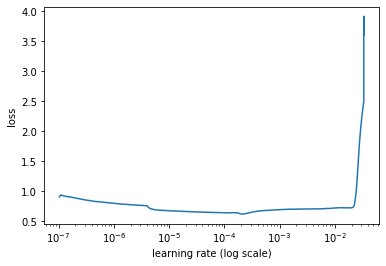

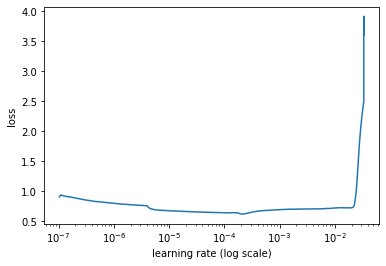

In [ ]:
#Find optimal learning rate
learner.lr_find(show_plot=True, max_epochs=5)
learner.lr_plot() 

In [ ]:
#Fit model
learner.fit_onecycle(5e-4, 4)



begin training using onecycle policy with max lr of 0.0005...
Epoch 1/4
1210/1210 [==============================] - 565s 467ms/step - loss: 0.6879 - accuracy: 0.5473 - val_loss: 0.6953 - val_accuracy: 0.4873
Epoch 2/4
1210/1210 [==============================] - 575s 475ms/step - loss: 0.7081 - accuracy: 0.4968 - val_loss: 0.7035 - val_accuracy: 0.4873
Epoch 3/4
1210/1210 [==============================] - 571s 472ms/step - loss: 0.7005 - accuracy: 0.4988 - val_loss: 0.6928 - val_accuracy: 0.5127
Epoch 4/4
1210/1210 [==============================] - 566s 468ms/step - loss: 0.6954 - accuracy: 0.5014 - val_loss: 0.6955 - val_accuracy: 0.4873


In [ ]:
#Validate
learner.validate()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3722
           1       0.49      1.00      0.66      3537

    accuracy                           0.49      7259
   macro avg       0.24      0.50      0.33      7259
weighted avg       0.24      0.49      0.32      7259



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[   0, 3722],
       [   0, 3537]])

In [ ]:
#Get predictor
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

#### Second try: news dataset

In [ ]:
df_news_bias = df_news
df_news_bias['is_biased'] = df_news_bias['rating'].apply(lambda row: 1 if row != 0.0 else 0)

In [ ]:
len(df_news_bias[df_news_bias['is_biased'] == 0])

56615

In [ ]:
df_news_bias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167863 entries, 301885 to 310898
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   article    167863 non-null  object 
 1   url        167863 non-null  object 
 2   publisher  167863 non-null  object 
 3   rating     167863 non-null  float64
 4   is_biased  167863 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 7.7+ MB


In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df_news_bias, 
                                                                   text_column='article',
                                                                   label_columns=["is_biased"],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=3)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
5596/5596 [==============================] - 2500s 447ms/step - loss: 0.1441 - accuracy: 0.9482
Epoch 2/5
5596/5596 [==============================] - 2489s 445ms/step - loss: 0.0642 - accuracy: 0.9743
Epoch 3/5
5596/5596 [==============================] - 2471s 442ms/step - loss: 0.6449 - accuracy: 0.6622


done.
Visually inspect loss plot and select learning rate associated with falling loss


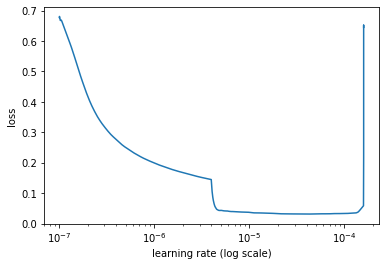

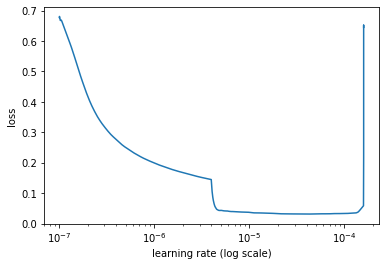

In [ ]:
#Find optimal learning rate
learner.lr_find(show_plot=True, max_epochs=5)
learner.lr_plot() 

In [ ]:
#Fit model
learner.fit_onecycle(5e-5, 4)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/4
5596/5596 [==============================] - 2645s 473ms/step - loss: 0.0369 - accuracy: 0.9885 - val_loss: 0.0213 - val_accuracy: 0.9937
Epoch 2/4
5596/5596 [==============================] - 2656s 475ms/step - loss: 0.0220 - accuracy: 0.9936 - val_loss: 0.0262 - val_accuracy: 0.9913
Epoch 3/4
5596/5596 [==============================] - 2656s 475ms/step - loss: 0.0174 - accuracy: 0.9950 - val_loss: 0.0208 - val_accuracy: 0.9954
Epoch 4/4
5596/5596 [==============================] - 2657s 475ms/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.0205 - val_accuracy: 0.9951


In [ ]:
#Validate
learner.validate()

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11375
           1       1.00      1.00      1.00     22198

    accuracy                           1.00     33573
   macro avg       0.99      0.99      0.99     33573
weighted avg       1.00      1.00      1.00     33573



array([[11294,    81],
       [   83, 22115]])

In [ ]:
#Get predictor
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [ ]:
#Save model
#predictor.save('/tmp/bias_predictor')

#Save to drive
save_file_to_drive("tf_model.h5", '/tmp/bias_predictor/tf_model.h5')
save_file_to_drive("tf_model.preproc", '/tmp/bias_predictor/tf_model.preproc')

File ID: 1Yb6JGMdY6bcywpXZ5gXEzUjjJfQAYzPT
File ID: 1vbTvDLR-0SATsBbQ5XlqECKuuk3Tl-z3


{'id': '1vbTvDLR-0SATsBbQ5XlqECKuuk3Tl-z3'}

#### Third try: news dataset Reddit

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1jSCMH2FltI19PNowoEgMKumrt42UdGXO/view?usp=sharing', 'third_bias_dataset_reddit_reuters.csv')

In [ ]:
df_news_bias = pd.read_csv('third_bias_dataset_reddit_reuters.csv')
df_news_bias['is_biased'] = df_news_bias['lean_right'].apply(lambda row: 1 if row != 0 else 0)
df_news_bias = df_news_bias[df_news_bias['text'].isna() == False]

In [ ]:
df_news_bias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143379 entries, 0 to 144346
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   lean_right  143379 non-null  int64 
 1   text        143379 non-null  object
 2   is_biased   143379 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.4+ MB


In [ ]:
df_news_bias.groupby(by='lean_right').count()

,text,is_biased
lean_right,,
-1,36648,36648
0,54032,54032
1,52699,52699


In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df_news_bias, 
                                                                   text_column='text',
                                                                   label_columns=["is_biased"],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=3)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
4780/4780 [==============================] - 2047s 428ms/step - loss: 0.1320 - accuracy: 0.9591
Epoch 2/5
4780/4780 [==============================] - 2008s 420ms/step - loss: 0.0542 - accuracy: 0.9770


done.
Visually inspect loss plot and select learning rate associated with falling loss


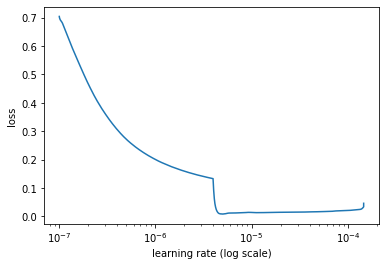

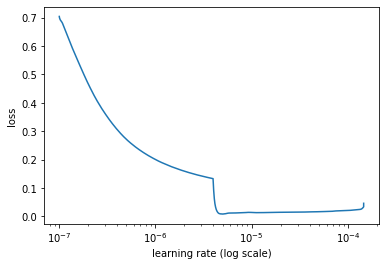

In [ ]:
#Find optimal learning rate
learner.lr_find(show_plot=True, max_epochs=5)
learner.lr_plot() 

In [ ]:
#Fit model
learner.fit_onecycle(5e-5, 4)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/4
4780/4780 [==============================] - 2147s 449ms/step - loss: 0.0216 - accuracy: 0.9946 - val_loss: 0.0131 - val_accuracy: 0.9968
Epoch 2/4
4780/4780 [==============================] - 2145s 449ms/step - loss: 0.0151 - accuracy: 0.9963 - val_loss: 0.0235 - val_accuracy: 0.9950
Epoch 3/4
4780/4780 [==============================] - 2135s 447ms/step - loss: 0.0126 - accuracy: 0.9970 - val_loss: 0.0137 - val_accuracy: 0.9968
Epoch 4/4
4780/4780 [==============================] - 2132s 446ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.0127 - val_accuracy: 0.9974


In [ ]:
#Validate
learner.validate()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10777
           1       1.00      1.00      1.00     17899

    accuracy                           1.00     28676
   macro avg       1.00      1.00      1.00     28676
weighted avg       1.00      1.00      1.00     28676



array([[10737,    40],
       [   35, 17864]])

In [ ]:
#Get predictor
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [ ]:
#Save model
predictor.save('/tmp/bias_predictor')

#Save to drive
save_file_to_drive("tf_model.h5", '/tmp/bias_predictor/tf_model.h5')
save_file_to_drive("tf_model.preproc", '/tmp/bias_predictor/tf_model.preproc')

File ID: 1URAq2pSMuVIHLpRmEpGYHkSvP4U2U-jD
File ID: 1HBDQ8a-veE9k30mFwy40hGcGC9QQrfsk


{'id': '1HBDQ8a-veE9k30mFwy40hGcGC9QQrfsk'}

### Political leaning ideology

#### First try: manually labeled dataset

In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df_news, 
                                                                   text_column='text',
                                                                   label_columns=["lean_left"],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=3)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
56/56 [==============================] - 32s 576ms/step - loss: 0.7575 - accuracy: 0.4533
Epoch 2/5
56/56 [==============================] - 32s 567ms/step - loss: 0.6888 - accuracy: 0.5901
Epoch 3/5
56/56 [==============================] - 32s 566ms/step - loss: 0.9556 - accuracy: 0.5206
Epoch 4/5
56/56 [==============================] - 32s 565ms/step - loss: 8.3418 - accuracy: 0.5228
Epoch 5/5
56/56 [==============================] - 32s 566ms/step - loss: 41.7381 - accuracy: 0.4944


done.
Visually inspect loss plot and select learning rate associated with falling loss


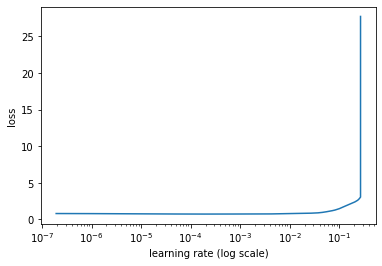

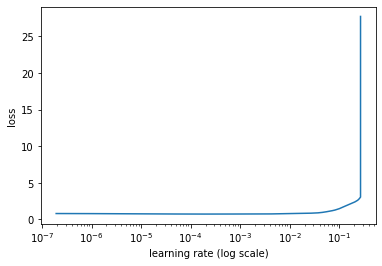

In [ ]:
#Find optimal learning rate
learner.lr_find(show_plot=True, max_epochs=5)
learner.lr_plot() 

In [ ]:
#Fit model
learner.fit_onecycle(5e-5, 10)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/10
56/56 [==============================] - 35s 623ms/step - loss: 0.1738 - accuracy: 0.9260 - val_loss: 0.9131 - val_accuracy: 0.6716
Epoch 2/10
56/56 [==============================] - 35s 620ms/step - loss: 0.1667 - accuracy: 0.9282 - val_loss: 1.0788 - val_accuracy: 0.6925
Epoch 3/10
56/56 [==============================] - 35s 619ms/step - loss: 0.1643 - accuracy: 0.9357 - val_loss: 1.0019 - val_accuracy: 0.6507
Epoch 4/10
56/56 [==============================] - 35s 617ms/step - loss: 0.1502 - accuracy: 0.9334 - val_loss: 1.1399 - val_accuracy: 0.6896
Epoch 5/10
56/56 [==============================] - 35s 616ms/step - loss: 0.1645 - accuracy: 0.9304 - val_loss: 1.1917 - val_accuracy: 0.6507
Epoch 6/10
56/56 [==============================] - 35s 619ms/step - loss: 0.2421 - accuracy: 0.8863 - val_loss: 0.9649 - val_accuracy: 0.6687
Epoch 7/10
56/56 [==============================] - 34s 616ms/step - loss: 0.17

In [ ]:
#Validate
learner.validate()

              precision    recall  f1-score   support

           0       0.68      0.56      0.62       142
           1       0.71      0.80      0.76       193

    accuracy                           0.70       335
   macro avg       0.70      0.68      0.69       335
weighted avg       0.70      0.70      0.70       335



array([[ 80,  62],
       [ 38, 155]])

In [ ]:
#Get predictor
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [ ]:
#Save model
predictor.save('/tmp/ideology_predictor')

In [ ]:
#Save to drive
save_file_to_drive("tf_model.h5", '/tmp/ideology_predictor/tf_model.h5')
save_file_to_drive("tf_model.preproc", '/tmp/ideology_predictor/tf_model.preproc')

File ID: 1aWb_a1597Cw2ChmkTr6SJ5-iqci59A15
File ID: 1rstcDHmqec5vHtOq1CFgOpqTnEzqd5uv


{'id': '1rstcDHmqec5vHtOq1CFgOpqTnEzqd5uv'}

In [ ]:
predictor.predict('Obama is the best')

'lean_left'

In [ ]:
predictor.predict('Russia’s Putin Praises ‘Ideological’ Links Between Democrats, Soviet Communism')

'not_lean_left'

In [ ]:
article = Article(url='https://edition.cnn.com/2020/10/06/opinions/us-election-biden-pennsylvania-nutter/index.html', config=config)
article.download()
article.parse()
article.nlp()
print(predictor.predict(article.text))
predictor.predict_proba(article.text)

lean_left


array([0.01566783, 0.9843322 ], dtype=float32)

In [ ]:
article = Article(url='https://www.breitbart.com/national-security/2020/10/07/russias-putin-praises-ideological-links-between-democrats-soviet-communism/', config=config)
article.download()
article.parse()
article.nlp()
print(predictor.predict(article.text))
predictor.predict_proba(article.text)

not_lean_left


array([0.9920557 , 0.00794431], dtype=float32)

#### Second try: news dataset
We use the dataset built from Kaggle + r/conservative

In [ ]:
df_ideology = df_news[df_news['rating'] != 0]
df_ideology['is_left'] = df_ideology['rating'].apply(lambda row: 1 if row < 0 else 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_ideology.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111325 entries, 122794 to 311104
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   article    111325 non-null  object 
 1   url        111325 non-null  object 
 2   publisher  111325 non-null  object 
 3   rating     111325 non-null  float64
 4   is_left    111325 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 5.1+ MB


In [ ]:
df_ideology.groupby(by='is_left').count()

,article,url,publisher,rating
is_left,,,,
0,53807,53807,53807,53807
1,57518,57518,57518,57518


In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df_ideology, 
                                                                   text_column='article',
                                                                   label_columns=['is_left'],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=1)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
3708/3708 [==============================] - 2248s 606ms/step - loss: 0.4555 - accuracy: 0.7805
Epoch 2/5
3708/3708 [==============================] - 2259s 609ms/step - loss: 0.2042 - accuracy: 0.9179
Epoch 3/5
3708/3708 [==============================] - 2265s 611ms/step - loss: 0.6914 - accuracy: 0.5202
Epoch 4/5
3708/3708 [==============================] - 2257s 609ms/step - loss: 1.7301 - accuracy: 0.5029


done.
Visually inspect loss plot and select learning rate associated with falling loss


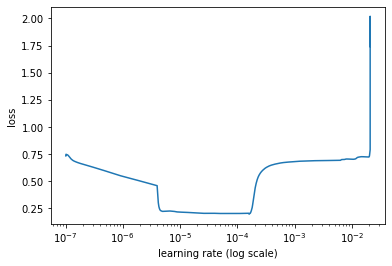

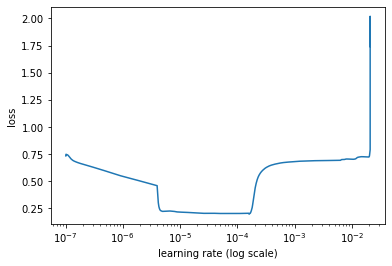

In [ ]:
#Find optimal learning rate
learner.lr_find(show_plot=True, max_epochs=5)
learner.lr_plot() 

In [ ]:
#Fit model
learner.fit_onecycle(5e-4, 4)



begin training using onecycle policy with max lr of 0.0005...
Epoch 1/4
3711/3711 [==============================] - 1769s 477ms/step - loss: 0.5578 - accuracy: 0.6368 - val_loss: 0.6944 - val_accuracy: 0.4864
Epoch 2/4
3711/3711 [==============================] - 1761s 474ms/step - loss: 0.7052 - accuracy: 0.5037 - val_loss: 0.6928 - val_accuracy: 0.5136
Epoch 3/4
3711/3711 [==============================] - 1759s 474ms/step - loss: 0.7035 - accuracy: 0.5034 - val_loss: 0.6986 - val_accuracy: 0.4864
Epoch 4/4
3711/3711 [==============================] - 1754s 473ms/step - loss: 0.6973 - accuracy: 0.5072 - val_loss: 0.6928 - val_accuracy: 0.5136


In [ ]:
learner.validate()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10829
           1       0.51      1.00      0.68     11436

    accuracy                           0.51     22265
   macro avg       0.26      0.50      0.34     22265
weighted avg       0.26      0.51      0.35     22265



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[    0, 10829],
       [    0, 11436]])

In [ ]:
#Get predictor
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [ ]:
#Save model
predictor.save('/tmp/ideology_predictor')

In [ ]:
#Save to drive
save_file_to_drive("tf_model.h5", '/tmp/ideology_predictor/tf_model.h5')
save_file_to_drive("tf_model.preproc", '/tmp/ideology_predictor/tf_model.preproc')

File ID: 1QfpfUQBHb-7ZA5G55xh6YDuGs5U3VZlJ
File ID: 1GyrUpPCUuKj209jlLMiv3UF8o7eOk3ul


{'id': '1GyrUpPCUuKj209jlLMiv3UF8o7eOk3ul'}

#### Reddit dataset
Dataset entirely from Reddit

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1jSCMH2FltI19PNowoEgMKumrt42UdGXO/view?usp=sharing', 'third_bias_dataset_reddit_reuters.csv')

In [ ]:
df_news_bias = pd.read_csv('third_bias_dataset_reddit_reuters.csv')
df_news_bias = df_news_bias[df_news_bias['lean_right'] != 0]
df_news_bias['lean_left'] = df_news_bias['lean_right'].apply(lambda row: 1 if row == -1 else 0)

In [ ]:
df_news_bias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89347 entries, 55000 to 144346
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lean_right  89347 non-null  int64 
 1   text        89347 non-null  object
 2   lean_left   89347 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.7+ MB


In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df_news_bias, 
                                                                   text_column='text',
                                                                   label_columns=['lean_left'],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=1)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
2979/2979 [==============================] - 1294s 434ms/step - loss: 0.5800 - accuracy: 0.6878
Epoch 2/5
2979/2979 [==============================] - 1294s 434ms/step - loss: 0.3296 - accuracy: 0.8585
Epoch 3/5
2979/2979 [==============================] - 1291s 433ms/step - loss: 0.6771 - accuracy: 0.5927
Epoch 4/5
2979/2979 [==============================] - 1291s 434ms/step - loss: 1.5167 - accuracy: 0.5200


done.
Visually inspect loss plot and select learning rate associated with falling loss


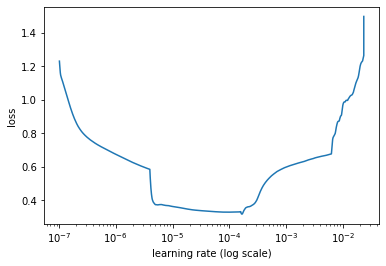

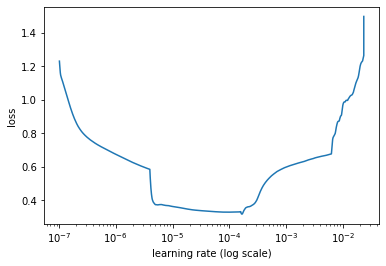

In [ ]:
#Find optimal learning rate
learner.lr_find(show_plot=True, max_epochs=5)
learner.lr_plot() 

In [ ]:
#Fit model
learner.fit_onecycle(1e-4, 4)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
2979/2979 [==============================] - 1315s 441ms/step - loss: 0.0437 - accuracy: 0.9858 - val_loss: 0.4089 - val_accuracy: 0.8834
Epoch 2/4
2979/2979 [==============================] - 1309s 439ms/step - loss: 0.0940 - accuracy: 0.9658 - val_loss: 0.3596 - val_accuracy: 0.8913
Epoch 3/4
2979/2979 [==============================] - 1314s 441ms/step - loss: 0.0845 - accuracy: 0.9698 - val_loss: 0.3438 - val_accuracy: 0.8922
Epoch 4/4
2979/2979 [==============================] - 1325s 445ms/step - loss: 0.0269 - accuracy: 0.9913 - val_loss: 0.4510 - val_accuracy: 0.8959


In [ ]:
learner.validate()

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     10548
           1       0.87      0.87      0.87      7322

    accuracy                           0.90     17870
   macro avg       0.89      0.89      0.89     17870
weighted avg       0.90      0.90      0.90     17870



array([[9616,  932],
       [ 928, 6394]])

In [ ]:
#Get predictor
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [ ]:
#Save model
predictor.save('/tmp/ideology_predictor')

In [ ]:
#Save to drive
save_file_to_drive("tf_model.h5", '/tmp/ideology_predictor/tf_model.h5')
save_file_to_drive("tf_model.preproc", '/tmp/ideology_predictor/tf_model.preproc')

File ID: 1q2o4Xo_4y871Ja080xO08sVlQDj95C2J
File ID: 1l3yocewbkS9neFHzyMLPi7rk8kUJDO7x


{'id': '1l3yocewbkS9neFHzyMLPi7rk8kUJDO7x'}